# About this Notebook

This Jupyter notebook is designed to load the training histories, including loss curves and validation MSE, from the best models obtained during our project. These results correspond to the optimization of the GCN baseline and the implementation of semi-supervised learning algorithms. The notebook reproduces the plots presented in our final report.

All training histories are stored in the `jp_data` directory in binary `.pkl` format.

### Importing Required Libraries

In [32]:
import os
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Loading and Listing Training History Files

This cell defines a helper function, `load_history(path)`, which loads a serialized training history stored in a `.pkl` file and converts it into a Pandas DataFrame. Each history contains per-epoch metrics (e.g., losses, validation MSE), and the function optionally sorts the entries by epoch to ensure consistent ordering.

After defining the loader, the cell scans the `jp_data/` directory for all available history files using `glob`. Each file is listed with an index so the user can easily select which run to load in later cells.


In [33]:
def load_history(path):
    with open(path, "rb") as f:
        history = pickle.load(f)
    # history is a list[dict]; convert to DataFrame
    df = pd.DataFrame(history)
    # sort by epoch just in case
    if "epoch" in df.columns:
        df = df.sort_values("epoch")
    return df

# List available files
files = sorted(glob.glob("../jp_data/*.pkl"))
print("Found files in jn_data/:")
for i, fpath in enumerate(files):
    print(f"[{i}] {fpath}")


Found files in jn_data/:
[0] ../jp_data/supervised_ensemble_best_architecture.pkl
[1] ../jp_data/supervised_ensemble_best_lr.pkl
[2] ../jp_data/supervised_ensemble_best_scheduler.pkl
[3] ../jp_data/supervised_ensemble_best_wd.pkl


### Selecting and Loading a Training Run

This cell allows you to manually choose which stored training run to load from the `jp_data/` directory.  
Each file corresponds to a different experiment performed during the optimization of our GCN baseline.  
The available files are indexed as follows:

| Index | File Name                                      | Description |
|-------|------------------------------------------------|-------------|
| **0** | `supervised_ensemble_best_architecture.pkl`    | Best-performing supervised model among the tested GNN architectures. |
| **1** | `supervised_ensemble_best_lr.pkl`              | Best supervised run found during the learning-rate sweep. |
| **2** | `supervised_ensemble_best_scheduler.pkl`       | Best supervised run according to different LR schedulers. |
| **3** | `supervised_ensemble_best_wd.pkl`              | Best supervised run discovered during the weight-decay optimization. |

To load one of these histories, set the variable `run_idx` to the desired index  
(e.g., `run_idx = 1` loads the learning-rate–optimized model).

The selected file is passed to `load_history()`, which returns a Pandas DataFrame containing  
all logged metrics. A post-processing step converts list-like values into floats  
to ensure the DataFrame is ready for plotting.


In [34]:
# Select index manually (e.g. 0, 1, 2...)
run_idx = 0  
selected_file = files[run_idx]
print("Using file:", selected_file)

df = load_history(selected_file)

for col in df.columns:
    df[col] = df[col].apply(lambda x: float(x) if isinstance(x, (list, np.ndarray)) else x)

df.head()


Using file: ../jp_data/supervised_ensemble_best_architecture.pkl


,epoch,supervised_loss,unsupervised_loss,total_loss,val_MSE
0,1,19.339417,0.0,19.339417,NaN
1,2,1.021728,0.0,1.021728,NaN
2,3,0.914994,0.0,0.914994,NaN
3,4,0.860100,0.0,0.860100,NaN
4,5,0.859185,0.0,0.859185,NaN


### Cleaning Metric Columns

Some metrics in the loaded history files appear as lists, NumPy arrays, scalars, or occasionally `None`.  
This cell defines `col_to_1d_float_array()`, a helper function that:

- Converts each value into a clean `float`
- Handles lists/arrays by extracting a scalar (mean if needed)
- Replaces invalid entries with `NaN`
- Returns a 1-D NumPy array ready for plotting

Using this function, the notebook extracts the available metrics (`epoch`, `supervised_loss`, `total_loss`, `unsupervised_loss`, `val_MSE`) in a consistent format for visualization.


In [35]:
def col_to_1d_float_array(series):
   
    cleaned = []
    for x in series:
       
        if x is None:
            cleaned.append(np.nan)
            continue

        
        try:
            arr = np.array(x)
        except Exception:
         
            try:
                cleaned.append(float(x))
                continue
            except Exception:
                cleaned.append(np.nan)
                continue

        
        if arr.ndim == 0:
            cleaned.append(float(arr))
        else:
            # Si tiene más dimensiones, usamos la media
            cleaned.append(float(arr.mean()))
    return np.array(cleaned, dtype=float)

epochs = col_to_1d_float_array(df["epoch"]) if "epoch" in df.columns else None
sup_loss = col_to_1d_float_array(df["supervised_loss"]) if "supervised_loss" in df.columns else None
tot_loss = col_to_1d_float_array(df["total_loss"]) if "total_loss" in df.columns else None
unsup_loss = col_to_1d_float_array(df["unsupervised_loss"]) if "unsupervised_loss" in df.columns else None
val_mse = col_to_1d_float_array(df["val_MSE"]) if "val_MSE" in df.columns else None

print("epochs:", epochs.shape, epochs[:5])
print("supervised_loss:", sup_loss.shape if sup_loss is not None else None)


epochs: (250,) [1. 2. 3. 4. 5.]
supervised_loss: (250,)


### Plotting Supervised and Total Loss

This cell visualizes the evolution of the supervised loss and, when available, the total loss across training epochs.  

The figure provides a quick overview of training dynamics, helping identify convergence behavior, instability, or divergence across different training configurations.


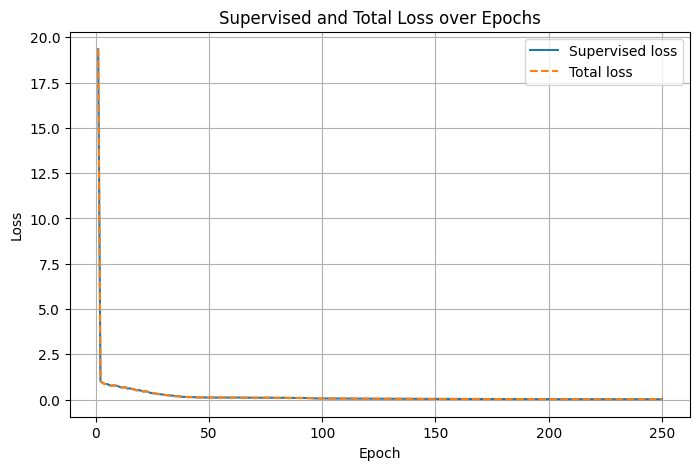

In [36]:
plt.figure(figsize=(8, 5))
if sup_loss is not None and epochs is not None:
    plt.plot(epochs, sup_loss, label="Supervised loss")
if tot_loss is not None and epochs is not None:
    plt.plot(epochs, tot_loss, label="Total loss", linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Supervised and Total Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Plotting Unsupervised Loss

This cell plots the unsupervised loss across epochs when the selected run corresponds to a semi-supervised method (CPS or Mean Teacher).  
For supervised models, this metric is not present and the plot is skipped automatically.

Visualizing the unsupervised loss helps assess how the consistency or pseudo-labeling signal evolves during training and whether it stabilizes or collapses.


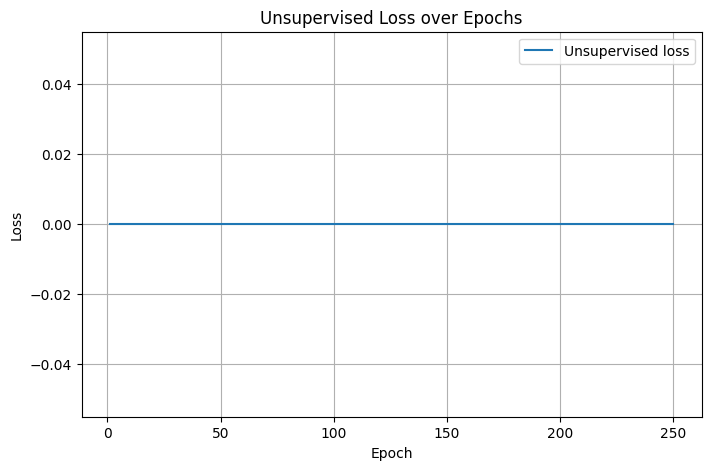

In [37]:
if unsup_loss is not None and epochs is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, unsup_loss, label="Unsupervised loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Unsupervised Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


### Validation MSE Plot

This cell visualizes the evolution of the **validation MSE** across training epochs.  
Validation MSE is the main metric used to compare models during hyperparameter tuning and to identify the best architecture or semi-supervised configuration.

A decreasing curve indicates improved generalization, while plateaus or increases suggest overfitting or instability.


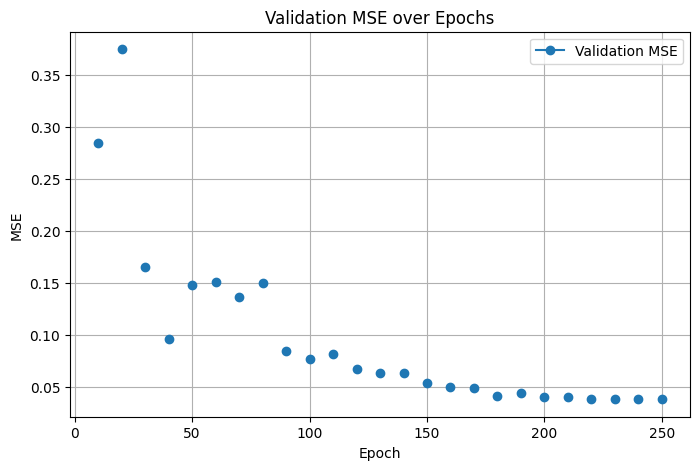

In [38]:
if val_mse is not None and epochs is not None:
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, val_mse, marker="o", label="Validation MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Validation MSE over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

